In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'blood'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [3]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

gtex_tissues = ['blood', 'k562']

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

#Loop over tissues
for gtex_tissue in gtex_tissues :
    
    print("tissue = '" + gtex_tissue + "'")

    score_file = h5py.File('scores_v2/gtex_' + gtex_tissue + '_log2fc_undo_clip_scores_mean.h5', 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Append hypothetical scores
    all_scores_hyp.append(scores[None, ...])

    #Append input-gated scores
    all_scores.append((scores * seqs)[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


tissue = 'blood'
tissue = 'k562'
scores_hyp.shape = (2, 200, 524288, 4)
scores.shape = (2, 200, 524288, 4)


0

-- Example = 0 --
 - ENSG00000169877(+)
 - chr16:31266321-31790609
 -- min_val = -0.9976
 -- max_val = 2.781
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


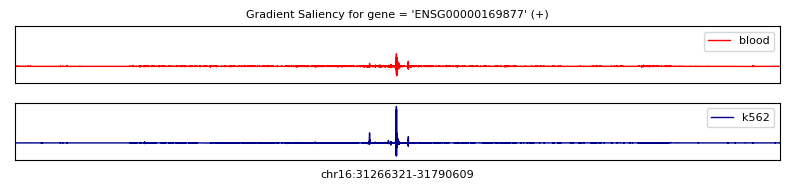

 - (Gradient score comparison against 'k562') - 
blood (r = 0.424)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


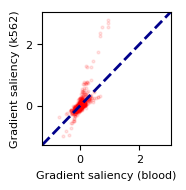

 - (Differential gradient score of k562 against 'mean') -


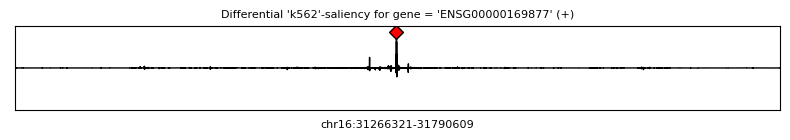

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261497
 - max_pos (abs) = 31527818
 - chr16:31527722-31527914
blood


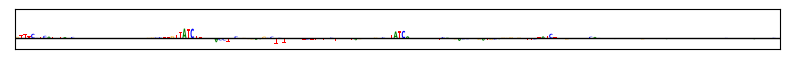

k562


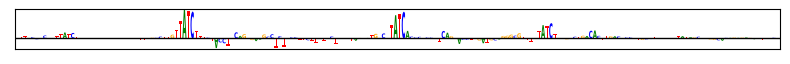

--------------------

-- Example = 1 --
 - ENSG00000206177(+)
 - chr16:-512-523776
 -- min_val = -0.4348
 -- max_val = 0.872
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


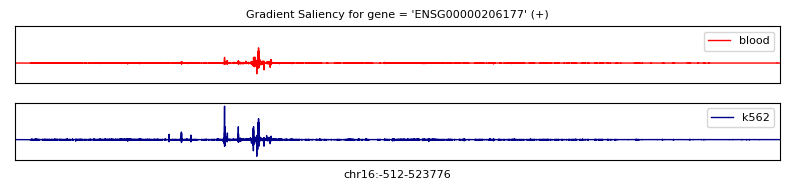

 - (Gradient score comparison against 'k562') - 
blood (r = 0.313)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


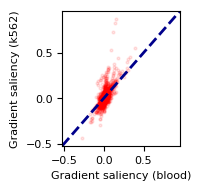

 - (Differential gradient score of k562 against 'mean') -


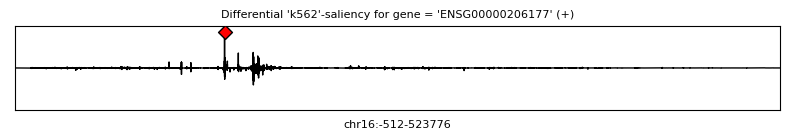

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 143679
 - max_pos (abs) = 143167
 - chr16:143071-143263
blood


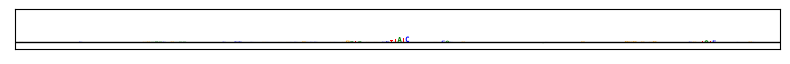

k562


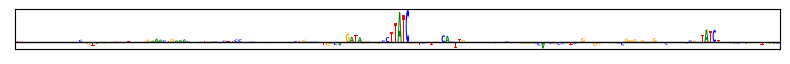

--------------------

-- Example = 2 --
 - ENSG00000118113(-)
 - chr11:102453605-102977893
 -- min_val = -0.4893
 -- max_val = 2.229
 - (Gradient score profiles per tissue) - 


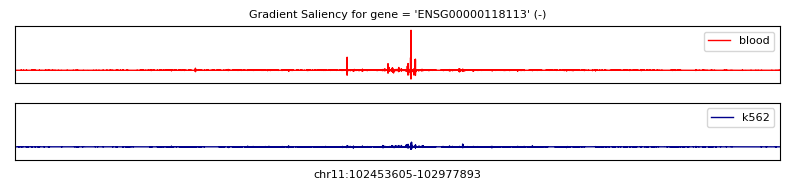

 - (Gradient score comparison against 'k562') - 
blood (r = 0.138)


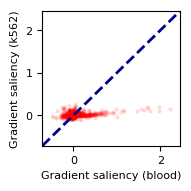

 - (Differential gradient score of k562 against 'mean') -


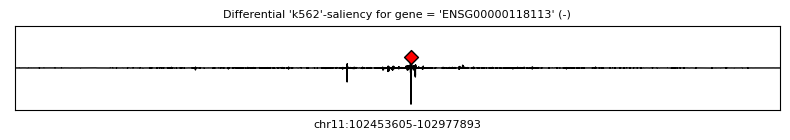

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271598
 - max_pos (abs) = 102725203
 - chr11:102725107-102725299
blood


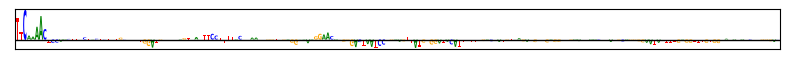

k562


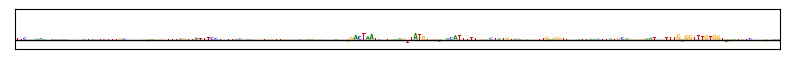

--------------------

-- Example = 3 --
 - ENSG00000110203(+)
 - chr11:71876423-72400711
 -- min_val = -2.77
 -- max_val = 5.344
 - (Gradient score profiles per tissue) - 


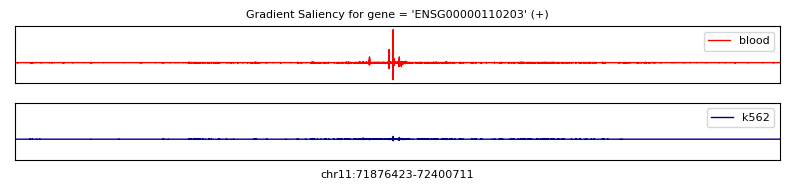

 - (Gradient score comparison against 'k562') - 
blood (r = 0.208)


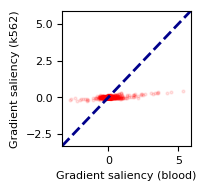

 - (Differential gradient score of k562 against 'mean') -


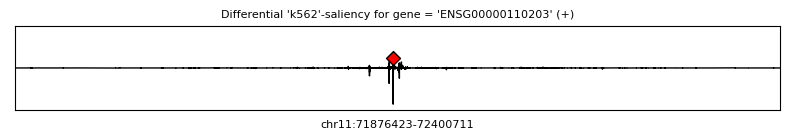

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259277
 - max_pos (abs) = 72135700
 - chr11:72135604-72135796
blood


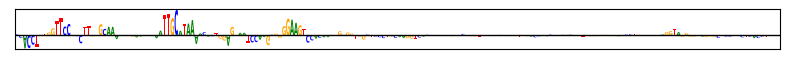

k562


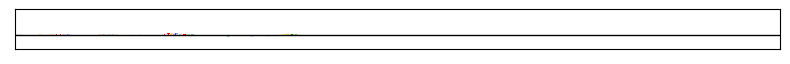

--------------------

-- Example = 4 --
 - ENSG00000126262(+)
 - chr19:35188458-35712746
 -- min_val = -0.3296
 -- max_val = 0.8706
 - (Gradient score profiles per tissue) - 


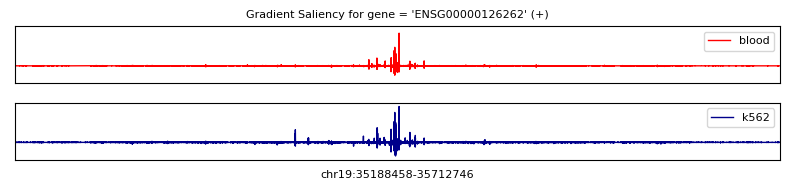

 - (Gradient score comparison against 'k562') - 
blood (r = 0.346)


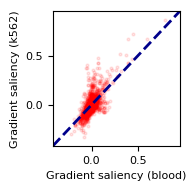

 - (Differential gradient score of k562 against 'mean') -


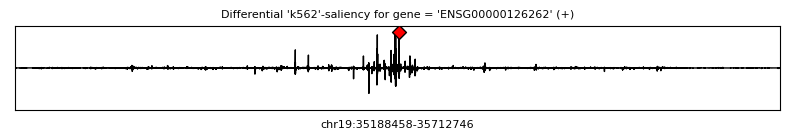

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263176
 - max_pos (abs) = 35451634
 - chr19:35451538-35451730
blood


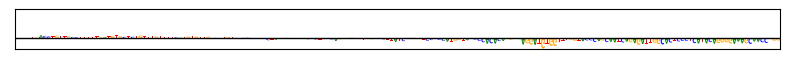

k562


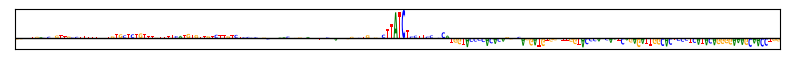

--------------------

-- Example = 5 --
 - ENSG00000004939(-)
 - chr17:43991866-44516154
 -- min_val = -1.139
 -- max_val = 3.2
 - (Gradient score profiles per tissue) - 


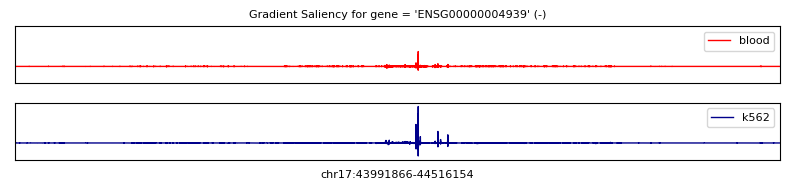

 - (Gradient score comparison against 'k562') - 
blood (r = 0.342)


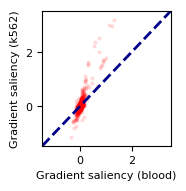

 - (Differential gradient score of k562 against 'mean') -


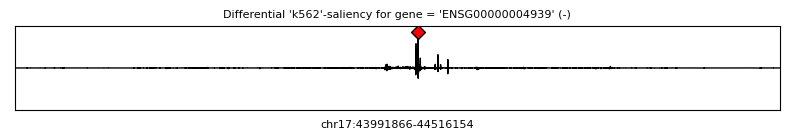

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 276408
 - max_pos (abs) = 44268274
 - chr17:44268178-44268370
blood


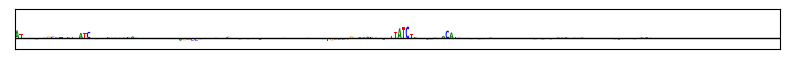

k562


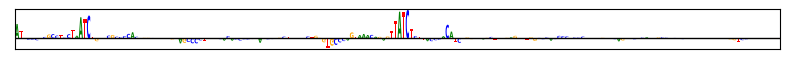

--------------------

-- Example = 6 --
 - ENSG00000171049(+)
 - chr19:51507222-52031510
 -- min_val = -1.027
 -- max_val = 2.541
 - (Gradient score profiles per tissue) - 


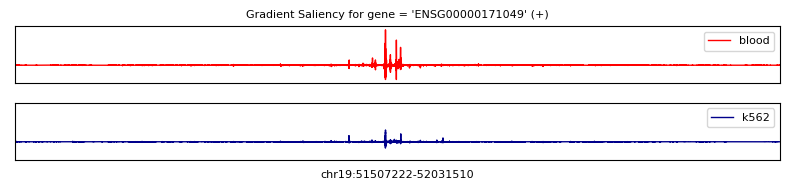

 - (Gradient score comparison against 'k562') - 
blood (r = 0.19)


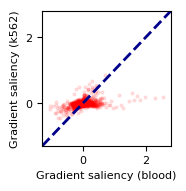

 - (Differential gradient score of k562 against 'mean') -


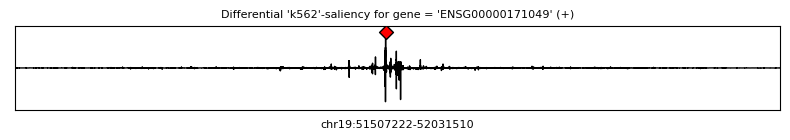

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254037
 - max_pos (abs) = 51761259
 - chr19:51761163-51761355
blood


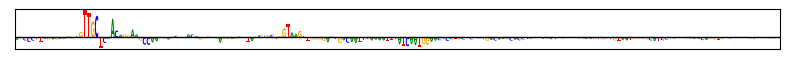

k562


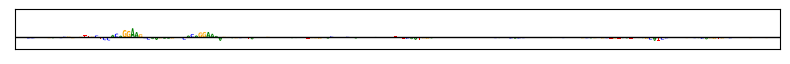

--------------------

-- Example = 7 --
 - ENSG00000180871(+)
 - chr2:217872624-218396912
 -- min_val = -1.531
 -- max_val = 1.089
 - (Gradient score profiles per tissue) - 


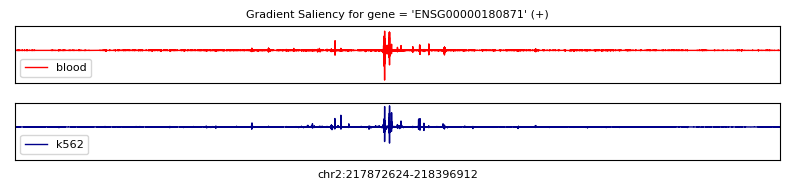

 - (Gradient score comparison against 'k562') - 
blood (r = 0.378)


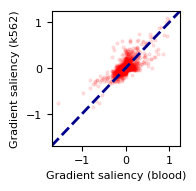

 - (Differential gradient score of k562 against 'mean') -


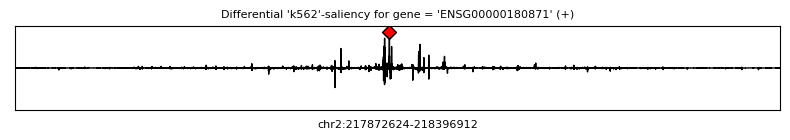

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 256637
 - max_pos (abs) = 218129261
 - chr2:218129165-218129357
blood


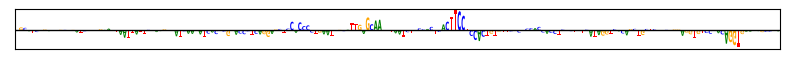

k562


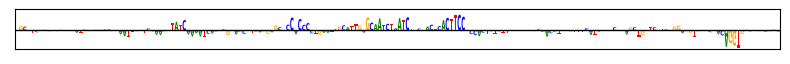

--------------------

-- Example = 8 --
 - ENSG00000204936(+)
 - chr19:43097819-43622107
 -- min_val = -0.3672
 -- max_val = 0.9526
 - (Gradient score profiles per tissue) - 


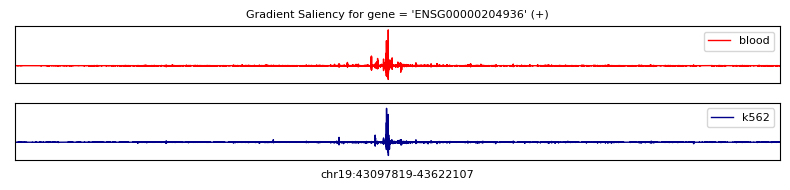

 - (Gradient score comparison against 'k562') - 
blood (r = 0.256)


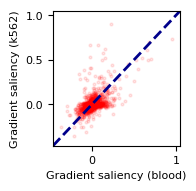

 - (Differential gradient score of k562 against 'mean') -


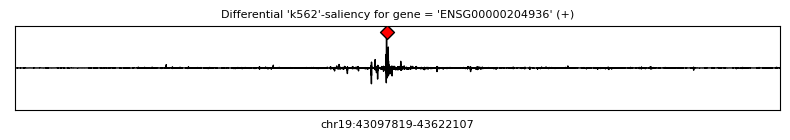

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254691
 - max_pos (abs) = 43352510
 - chr19:43352414-43352606
blood


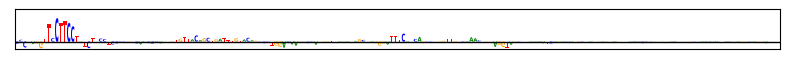

k562


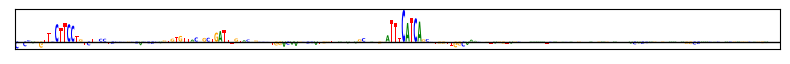

--------------------

-- Example = 9 --
 - ENSG00000112195(-)
 - chr6:40930526-41454814
 -- min_val = -1.528
 -- max_val = 1.714
 - (Gradient score profiles per tissue) - 


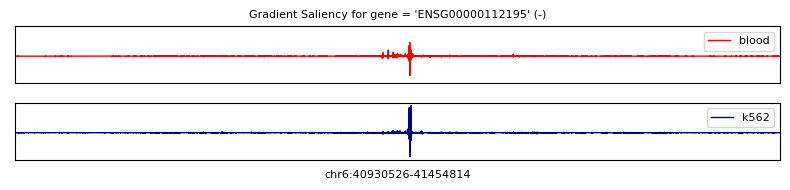

 - (Gradient score comparison against 'k562') - 
blood (r = 0.134)


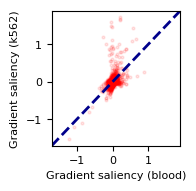

 - (Differential gradient score of k562 against 'mean') -


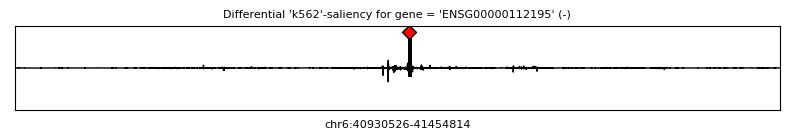

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 270078
 - max_pos (abs) = 41200604
 - chr6:41200508-41200700
blood


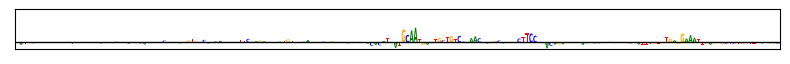

k562


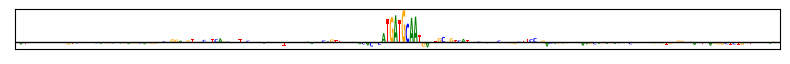

--------------------

-- Example = 10 --
 - ENSG00000255398(-)
 - chr12:122453638-122977926
 -- min_val = -0.9014
 -- max_val = 1.314
 - (Gradient score profiles per tissue) - 


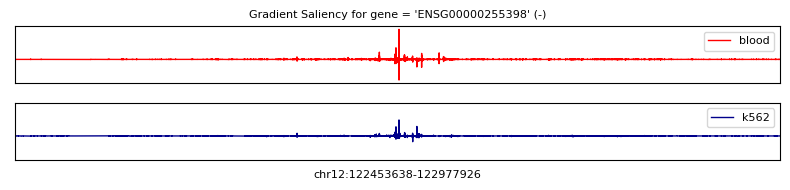

 - (Gradient score comparison against 'k562') - 
blood (r = 0.219)


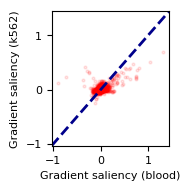

 - (Differential gradient score of k562 against 'mean') -


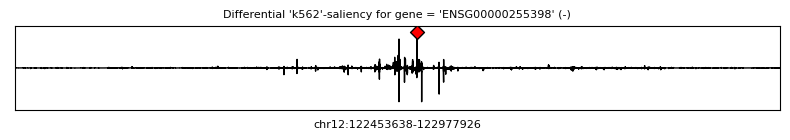

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 275462
 - max_pos (abs) = 122729100
 - chr12:122729004-122729196
blood


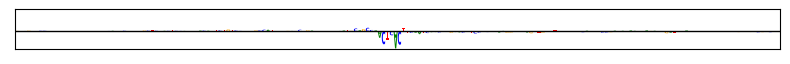

k562


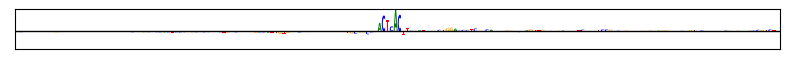

--------------------

-- Example = 11 --
 - ENSG00000158578(-)
 - chrX:54755896-55280184
 -- min_val = -0.3555
 -- max_val = 0.6787
 - (Gradient score profiles per tissue) - 


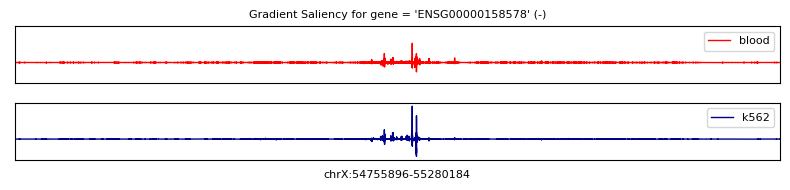

 - (Gradient score comparison against 'k562') - 
blood (r = 0.17)


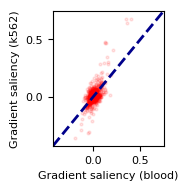

 - (Differential gradient score of k562 against 'mean') -


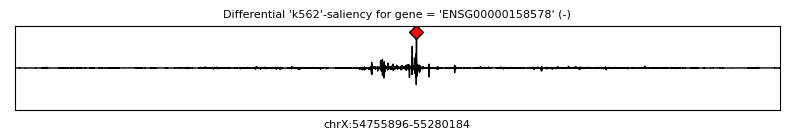

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 275205
 - max_pos (abs) = 55031101
 - chrX:55031005-55031197
blood


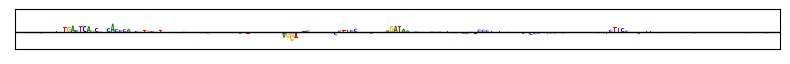

k562


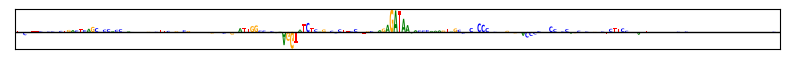

--------------------

-- Example = 12 --
 - ENSG00000124731(-)
 - chr6:41014251-41538539
 -- min_val = -1.457
 -- max_val = 2.768
 - (Gradient score profiles per tissue) - 


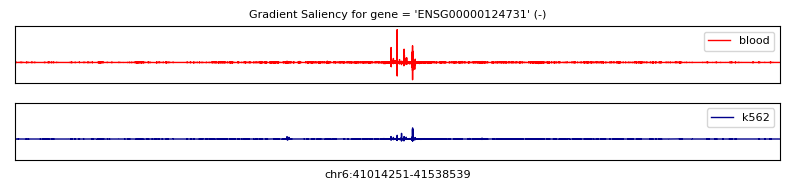

 - (Gradient score comparison against 'k562') - 
blood (r = 0.036)


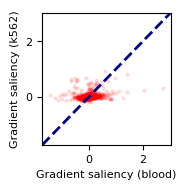

 - (Differential gradient score of k562 against 'mean') -


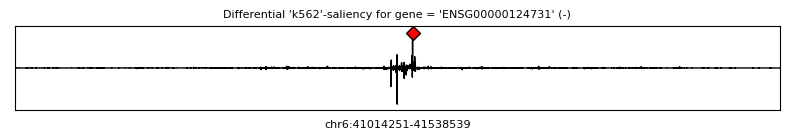

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272516
 - max_pos (abs) = 41286767
 - chr6:41286671-41286863
blood


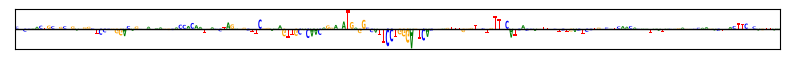

k562


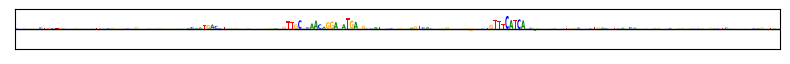

--------------------

-- Example = 13 --
 - ENSG00000164821(-)
 - chr8:6674413-7198701
 -- min_val = -1.071
 -- max_val = 2.756
 - (Gradient score profiles per tissue) - 


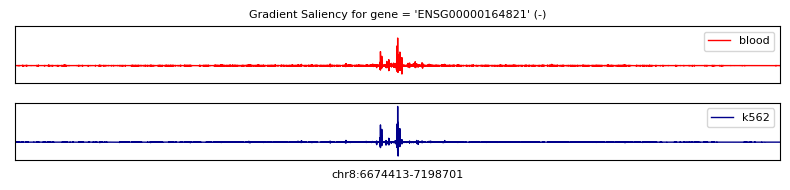

 - (Gradient score comparison against 'k562') - 
blood (r = 0.643)


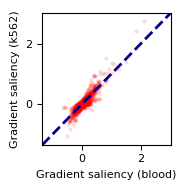

 - (Differential gradient score of k562 against 'mean') -


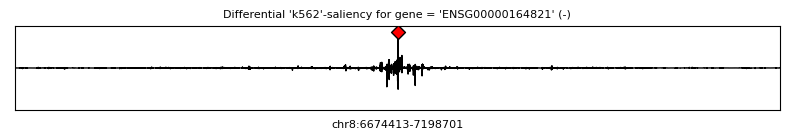

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262589
 - max_pos (abs) = 6937002
 - chr8:6936906-6937098
blood


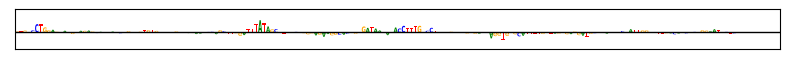

k562


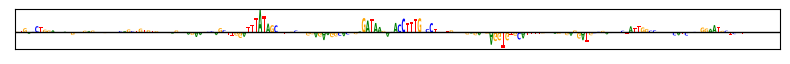

--------------------

-- Example = 14 --
 - ENSG00000183019(+)
 - chr19:7416744-7941032
 -- min_val = -1.334
 -- max_val = 2.527
 - (Gradient score profiles per tissue) - 


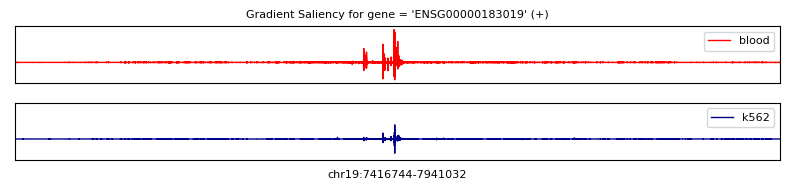

 - (Gradient score comparison against 'k562') - 
blood (r = 0.23)


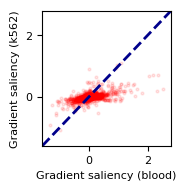

 - (Differential gradient score of k562 against 'mean') -


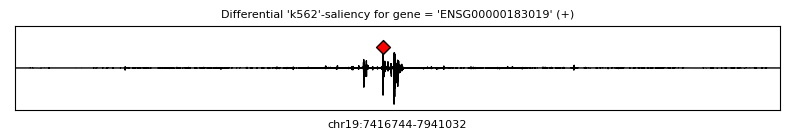

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 252390
 - max_pos (abs) = 7669134
 - chr19:7669038-7669230
blood


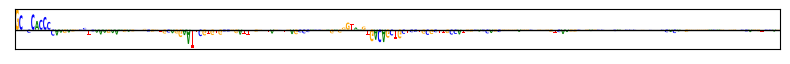

k562


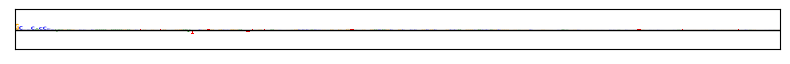

--------------------

-- Example = 15 --
 - ENSG00000105205(-)
 - chr19:39471649-39995937
 -- min_val = -0.925
 -- max_val = 1.239
 - (Gradient score profiles per tissue) - 


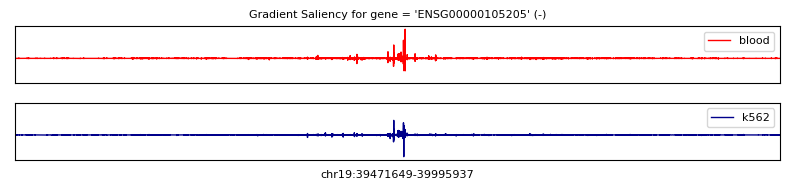

 - (Gradient score comparison against 'k562') - 
blood (r = 0.155)


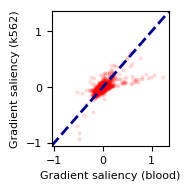

 - (Differential gradient score of k562 against 'mean') -


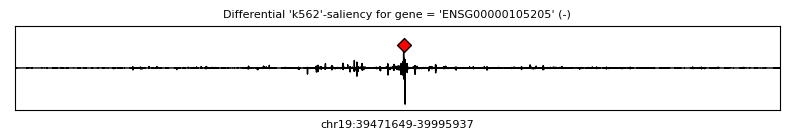

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266384
 - max_pos (abs) = 39738033
 - chr19:39737937-39738129
blood


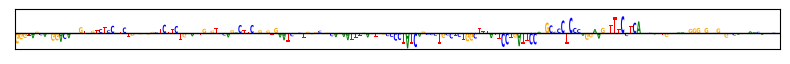

k562


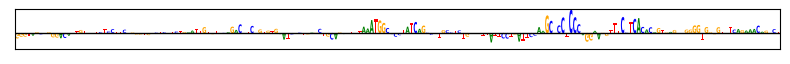

--------------------

-- Example = 16 --
 - ENSG00000170956(+)
 - chr19:41542701-42066989
 -- min_val = -0.3452
 -- max_val = 0.7017
 - (Gradient score profiles per tissue) - 


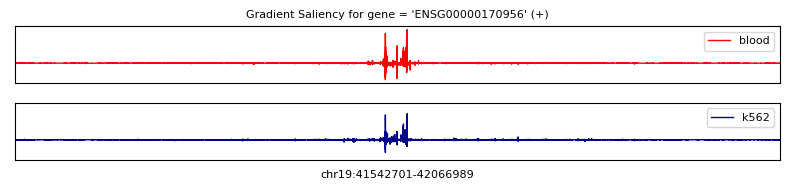

 - (Gradient score comparison against 'k562') - 
blood (r = 0.222)


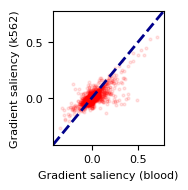

 - (Differential gradient score of k562 against 'mean') -


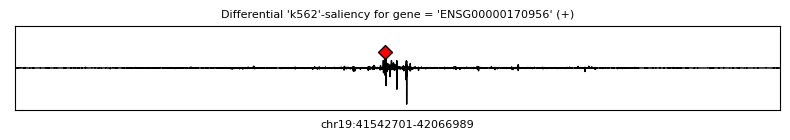

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 253838
 - max_pos (abs) = 41796539
 - chr19:41796443-41796635
blood


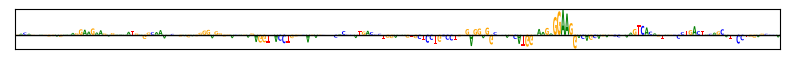

k562


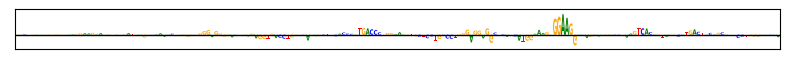

--------------------

-- Example = 17 --
 - ENSG00000163421(-)
 - chr3:71512521-72036809
 -- min_val = -0.6665
 -- max_val = 1.712
 - (Gradient score profiles per tissue) - 


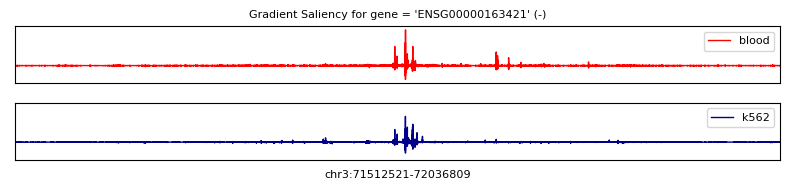

 - (Gradient score comparison against 'k562') - 
blood (r = 0.305)


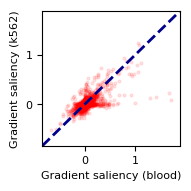

 - (Differential gradient score of k562 against 'mean') -


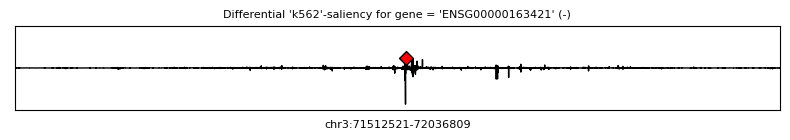

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 267729
 - max_pos (abs) = 71780250
 - chr3:71780154-71780346
blood


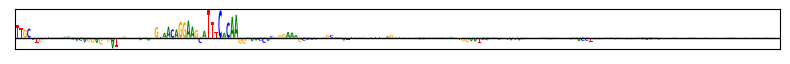

k562


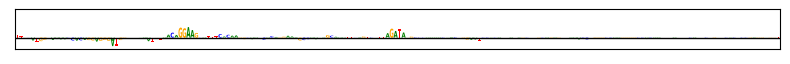

--------------------

-- Example = 18 --
 - ENSG00000131355(-)
 - chr19:14380540-14904828
 -- min_val = -0.4062
 -- max_val = 1.104
 - (Gradient score profiles per tissue) - 


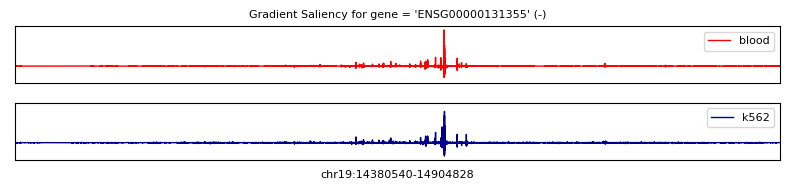

 - (Gradient score comparison against 'k562') - 
blood (r = 0.275)


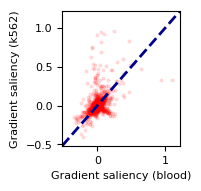

 - (Differential gradient score of k562 against 'mean') -


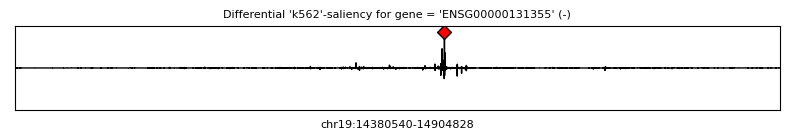

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 294355
 - max_pos (abs) = 14674895
 - chr19:14674799-14674991
blood


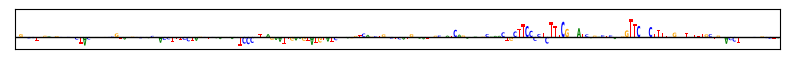

k562


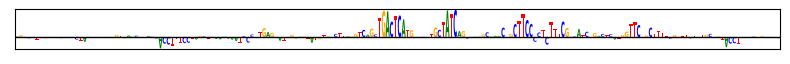

--------------------

-- Example = 19 --
 - ENSG00000128383(+)
 - chr22:38699581-39223869
 -- min_val = -0.641
 -- max_val = 2.65
 - (Gradient score profiles per tissue) - 


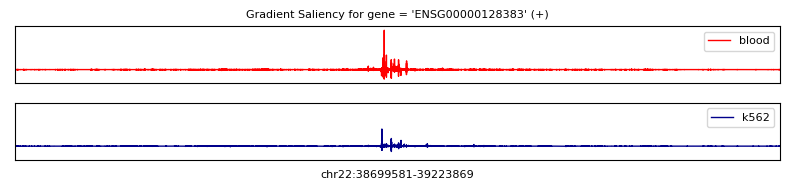

 - (Gradient score comparison against 'k562') - 
blood (r = 0.209)


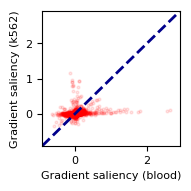

 - (Differential gradient score of k562 against 'mean') -


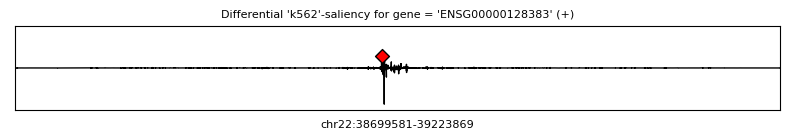

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251454
 - max_pos (abs) = 38951035
 - chr22:38950939-38951131
blood


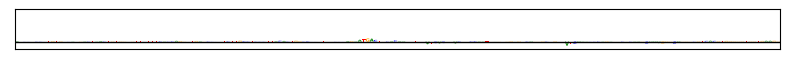

k562


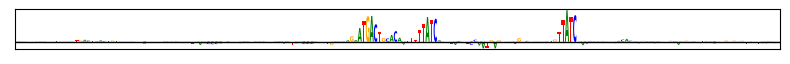

--------------------

-- Example = 20 --
 - ENSG00000186431(+)
 - chr19:54626701-55150989
 -- min_val = -1.631
 -- max_val = 2.191
 - (Gradient score profiles per tissue) - 


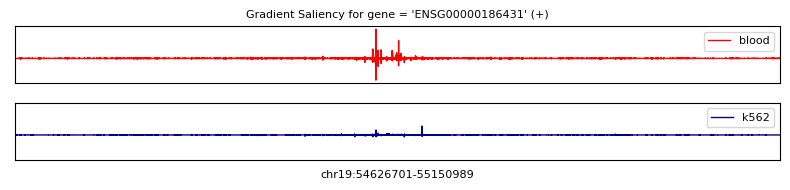

 - (Gradient score comparison against 'k562') - 
blood (r = 0.019)


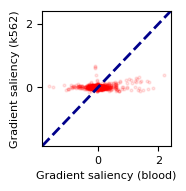

 - (Differential gradient score of k562 against 'mean') -


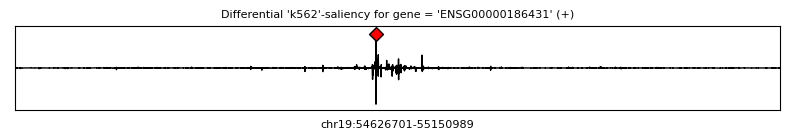

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 247544
 - max_pos (abs) = 54874245
 - chr19:54874149-54874341
blood


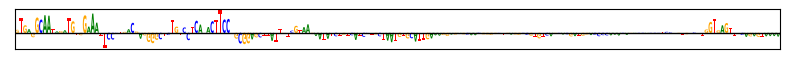

k562


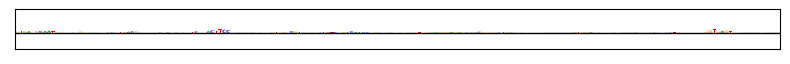

--------------------

-- Example = 21 --
 - ENSG00000008438(-)
 - chr19:45758818-46283106
 -- min_val = -2.086
 -- max_val = 3.18
 - (Gradient score profiles per tissue) - 


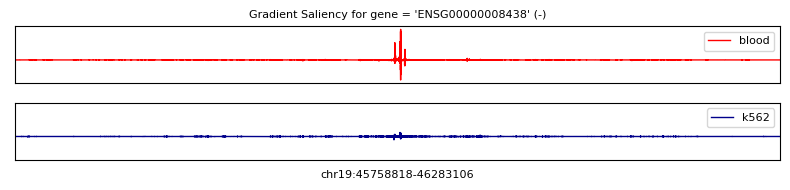

 - (Gradient score comparison against 'k562') - 
blood (r = 0.142)


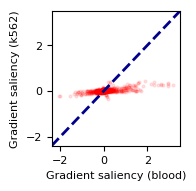

 - (Differential gradient score of k562 against 'mean') -


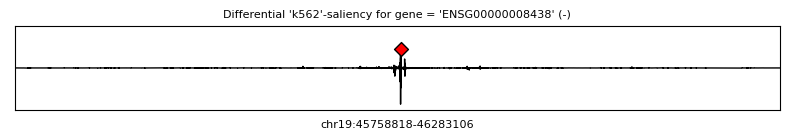

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264276
 - max_pos (abs) = 46023094
 - chr19:46022998-46023190
blood


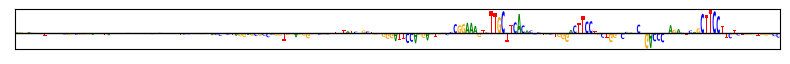

k562


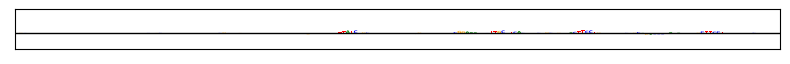

--------------------

-- Example = 22 --
 - ENSG00000166947(-)
 - chr15:42946773-43471061
 -- min_val = -1.677
 -- max_val = inf
 - (Gradient score profiles per tissue) - 


/tmp/ipykernel_490989/2459634516.py:41: RuntimeWarning: overflow encountered in multiply
  print(" -- max_val = " + str(round(max_val, 4)))


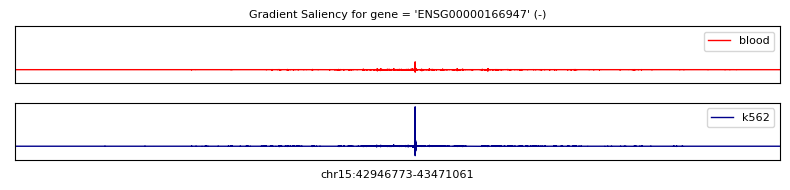

 - (Gradient score comparison against 'k562') - 
blood (r = 0.307)


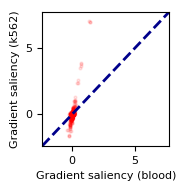

 - (Differential gradient score of k562 against 'mean') -


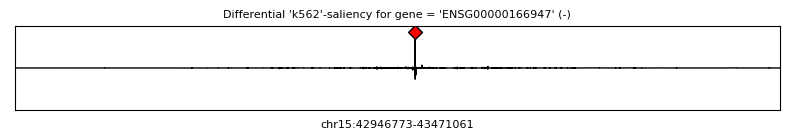

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 274302
 - max_pos (abs) = 43221075
 - chr15:43220979-43221171
blood


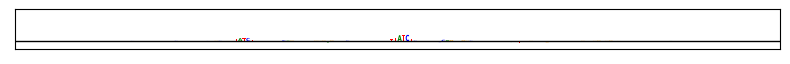

k562


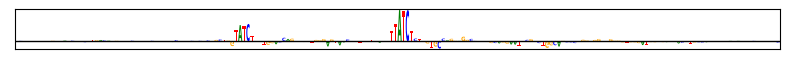

--------------------

-- Example = 23 --
 - ENSG00000163464(-)
 - chr2:217901962-218426250
 -- min_val = -1.794
 -- max_val = 2.613
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


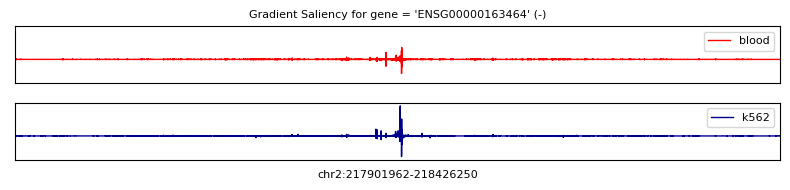

 - (Gradient score comparison against 'k562') - 
blood (r = 0.247)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


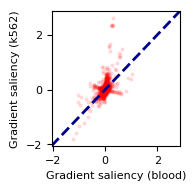

 - (Differential gradient score of k562 against 'mean') -


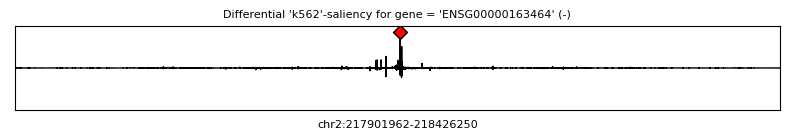

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264064
 - max_pos (abs) = 218166026
 - chr2:218165930-218166122
blood


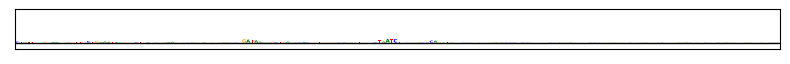

k562


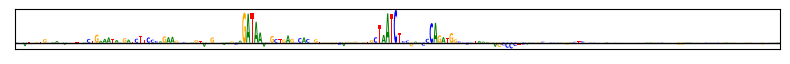

--------------------

-- Example = 24 --
 - ENSG00000173535(+)
 - chr8:22851573-23375861
 -- min_val = -0.8164
 -- max_val = 1.1875
 - (Gradient score profiles per tissue) - 


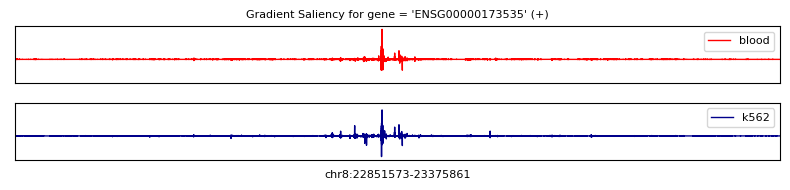

 - (Gradient score comparison against 'k562') - 
blood (r = 0.359)


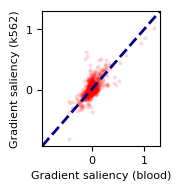

 - (Differential gradient score of k562 against 'mean') -


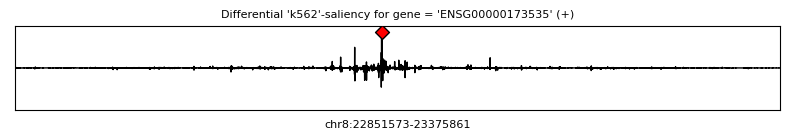

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251722
 - max_pos (abs) = 23103295
 - chr8:23103199-23103391
blood


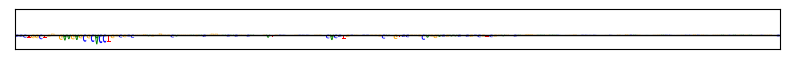

k562


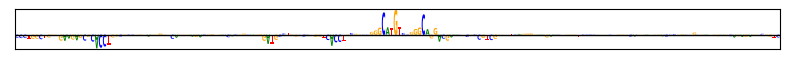

--------------------

-- Example = 25 --
 - ENSG00000104918(+)
 - chr19:7407705-7931993
 -- min_val = -1.053
 -- max_val = 1.348
 - (Gradient score profiles per tissue) - 


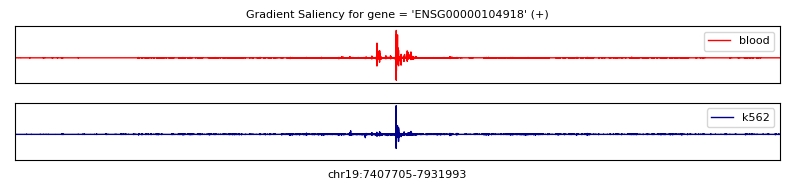

 - (Gradient score comparison against 'k562') - 
blood (r = 0.196)


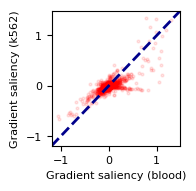

 - (Differential gradient score of k562 against 'mean') -


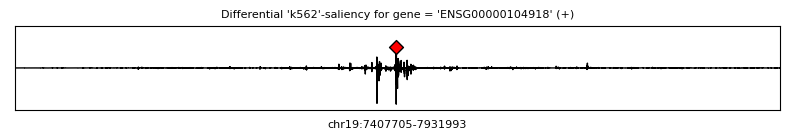

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261285
 - max_pos (abs) = 7668990
 - chr19:7668894-7669086
blood


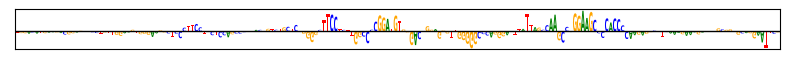

k562


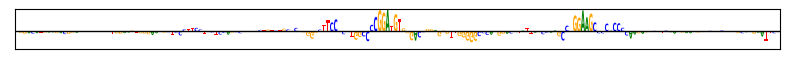

--------------------

-- Example = 26 --
 - ENSG00000213934(-)
 - chr11:4986998-5511286
 -- min_val = -0.1702
 -- max_val = 0.423
 - (Gradient score profiles per tissue) - 


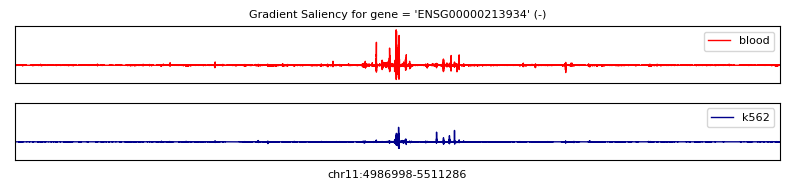

 - (Gradient score comparison against 'k562') - 
blood (r = 0.086)


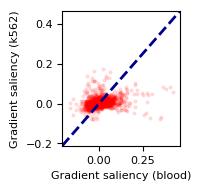

 - (Differential gradient score of k562 against 'mean') -


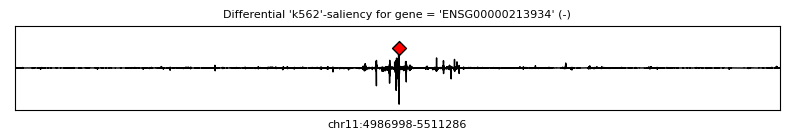

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262969
 - max_pos (abs) = 5249967
 - chr11:5249871-5250063
blood


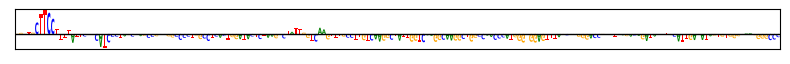

k562


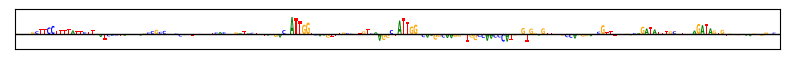

--------------------

-- Example = 27 --
 - ENSG00000196565(-)
 - chr11:4991922-5516210
 -- min_val = -0.1904
 -- max_val = 0.4688
 - (Gradient score profiles per tissue) - 


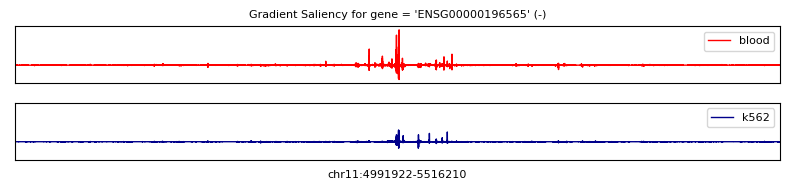

 - (Gradient score comparison against 'k562') - 
blood (r = 0.152)


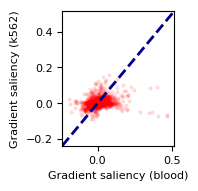

 - (Differential gradient score of k562 against 'mean') -


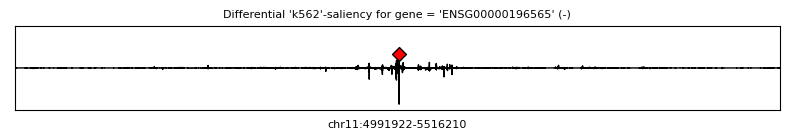

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 262969
 - max_pos (abs) = 5254891
 - chr11:5254795-5254987
blood


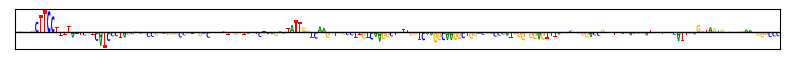

k562


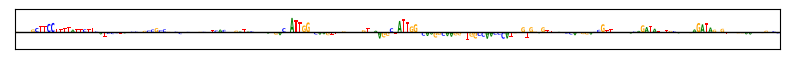

--------------------

-- Example = 28 --
 - ENSG00000169397(+)
 - chr14:20629815-21154103
 -- min_val = -0.6494
 -- max_val = 2.234
 - (Gradient score profiles per tissue) - 


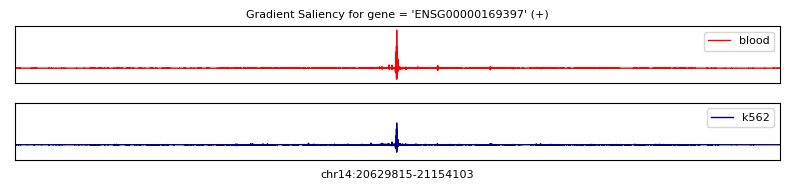

 - (Gradient score comparison against 'k562') - 
blood (r = 0.435)


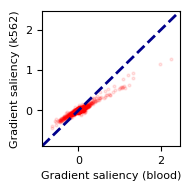

 - (Differential gradient score of k562 against 'mean') -


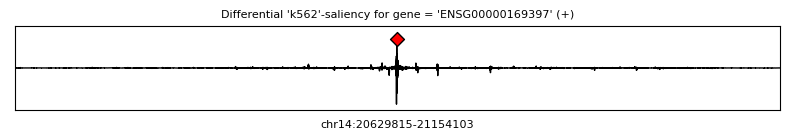

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261660
 - max_pos (abs) = 20891475
 - chr14:20891379-20891571
blood


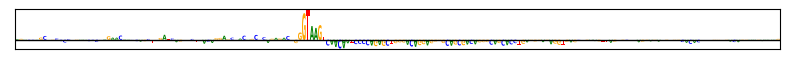

k562


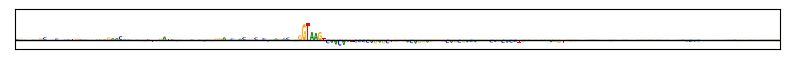

--------------------

-- Example = 29 --
 - ENSG00000182782(-)
 - chr12:122440180-122964468
 -- min_val = -0.2896
 -- max_val = 0.7026
 - (Gradient score profiles per tissue) - 


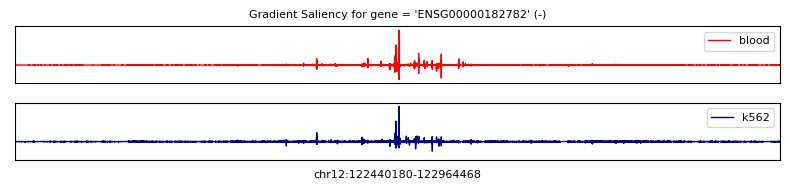

 - (Gradient score comparison against 'k562') - 
blood (r = 0.176)


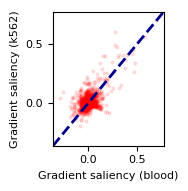

 - (Differential gradient score of k562 against 'mean') -


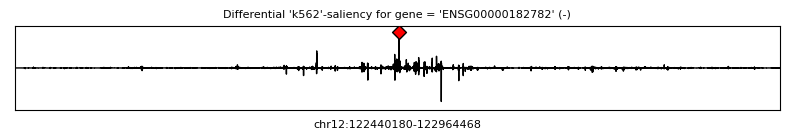

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263302
 - max_pos (abs) = 122703482
 - chr12:122703386-122703578
blood


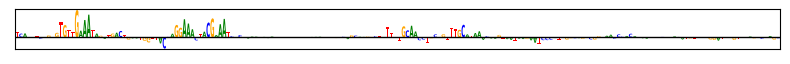

k562


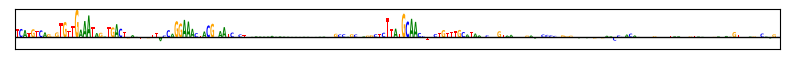

--------------------

-- Example = 30 --
 - ENSG00000163737(-)
 - chr4:73719167-74243455
 -- min_val = -0.411
 -- max_val = 0.96
 - (Gradient score profiles per tissue) - 


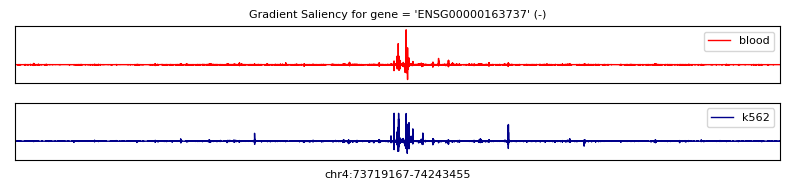

 - (Gradient score comparison against 'k562') - 
blood (r = 0.179)


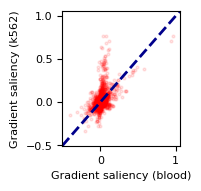

 - (Differential gradient score of k562 against 'mean') -


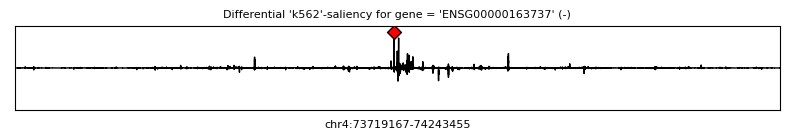

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 259870
 - max_pos (abs) = 73979037
 - chr4:73978941-73979133
blood


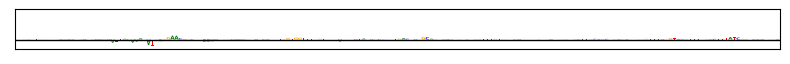

k562


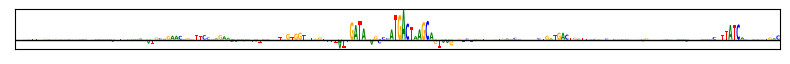

--------------------

-- Example = 31 --
 - ENSG00000159339(+)
 - chr1:17085559-17609847
 -- min_val = -2.875
 -- max_val = 2.506
 - (Gradient score profiles per tissue) - 


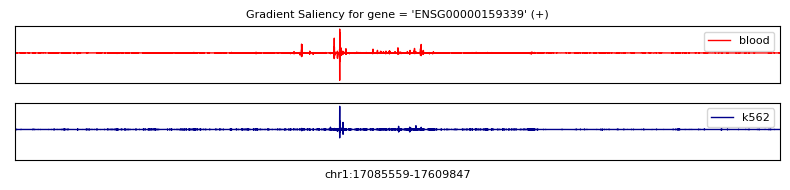

 - (Gradient score comparison against 'k562') - 
blood (r = 0.221)


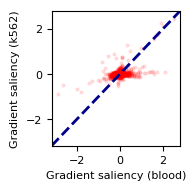

 - (Differential gradient score of k562 against 'mean') -


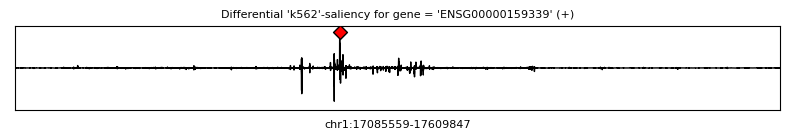

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 222582
 - max_pos (abs) = 17308141
 - chr1:17308045-17308237
blood


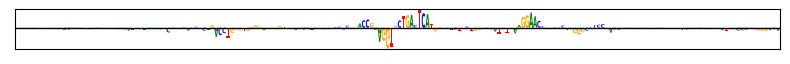

k562


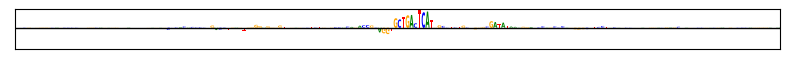

--------------------

-- Example = 32 --
 - ENSG00000204010(+)
 - chr10:89121851-89646139
 -- min_val = -0.955
 -- max_val = 1.596
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


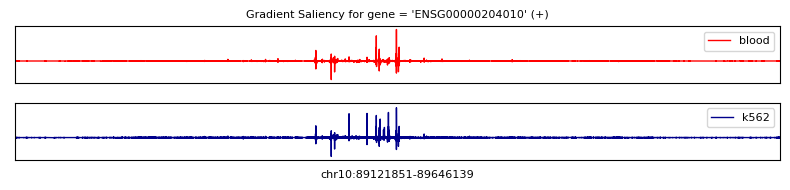

 - (Gradient score comparison against 'k562') - 
blood (r = 0.709)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


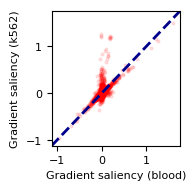

 - (Differential gradient score of k562 against 'mean') -


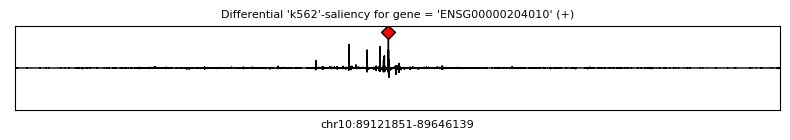

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 255977
 - max_pos (abs) = 89377828
 - chr10:89377732-89377924
blood


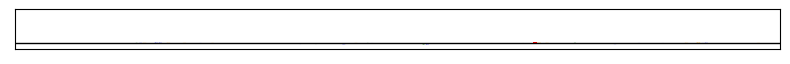

k562


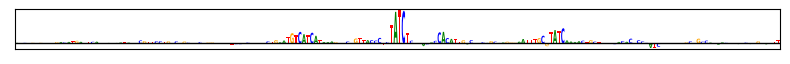

--------------------

-- Example = 33 --
 - ENSG00000134827(-)
 - chr11:59596271-60120559
 -- min_val = -1.652
 -- max_val = 1.982
 - (Gradient score profiles per tissue) - 


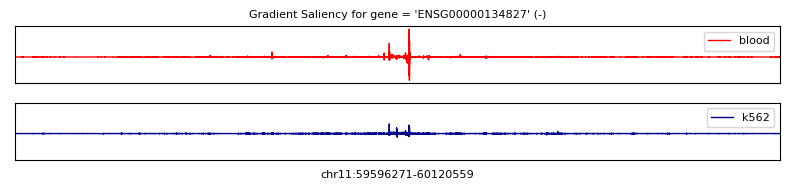

 - (Gradient score comparison against 'k562') - 
blood (r = 0.227)


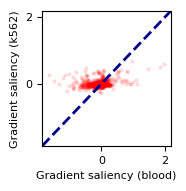

 - (Differential gradient score of k562 against 'mean') -


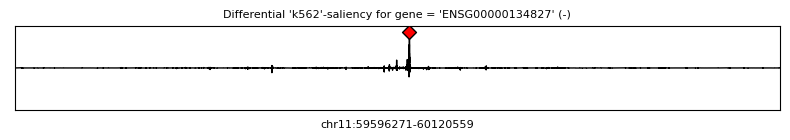

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 270359
 - max_pos (abs) = 59866630
 - chr11:59866534-59866726
blood


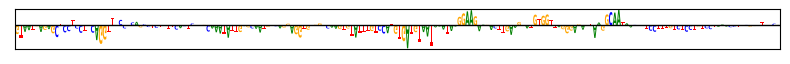

k562


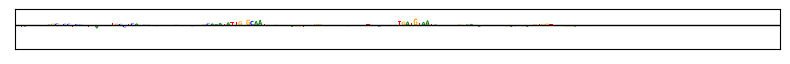

--------------------

-- Example = 34 --
 - ENSG00000123405(-)
 - chr12:54031914-54556202
 -- min_val = -1.297
 -- max_val = 1.383
 - (Gradient score profiles per tissue) - 


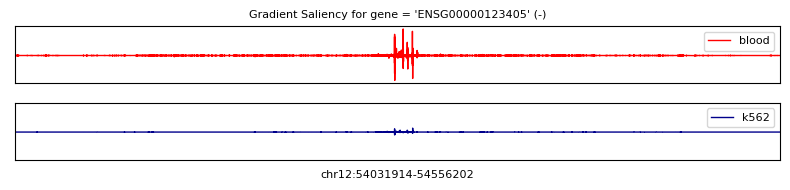

 - (Gradient score comparison against 'k562') - 
blood (r = 0.105)


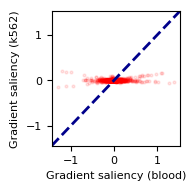

 - (Differential gradient score of k562 against 'mean') -


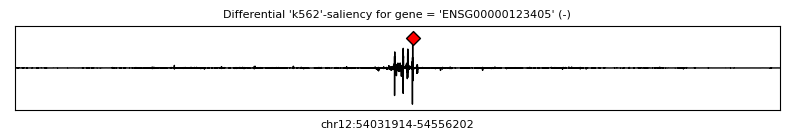

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 272587
 - max_pos (abs) = 54304501
 - chr12:54304405-54304597
blood


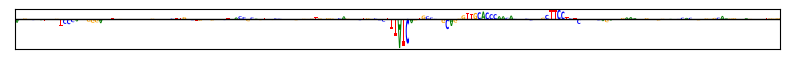

k562


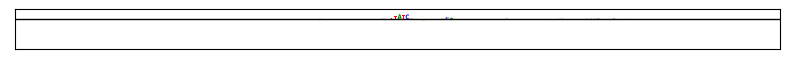

--------------------

-- Example = 35 --
 - ENSG00000124469(-)
 - chr19:42323768-42848056
 -- min_val = -0.5645
 -- max_val = 1.043
 - (Gradient score profiles per tissue) - 


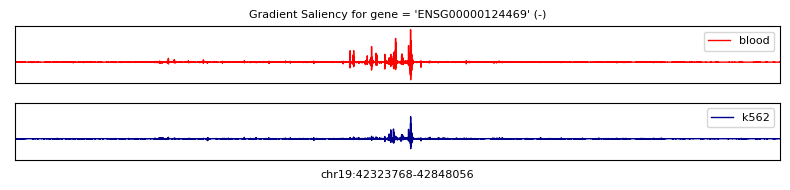

 - (Gradient score comparison against 'k562') - 
blood (r = 0.326)


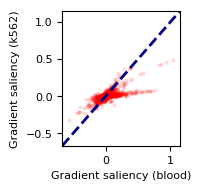

 - (Differential gradient score of k562 against 'mean') -


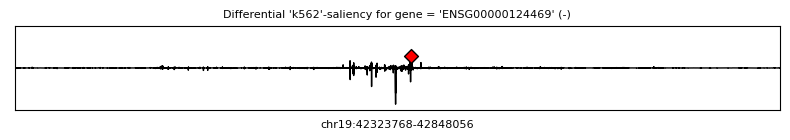

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271225
 - max_pos (abs) = 42594993
 - chr19:42594897-42595089
blood


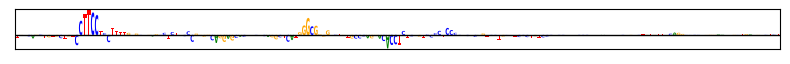

k562


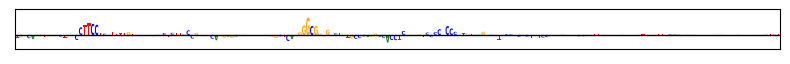

--------------------

-- Example = 36 --
 - ENSG00000189068(-)
 - chr19:53788928-54313216
 -- min_val = -2.086
 -- max_val = 2.707
 - (Gradient score profiles per tissue) - 


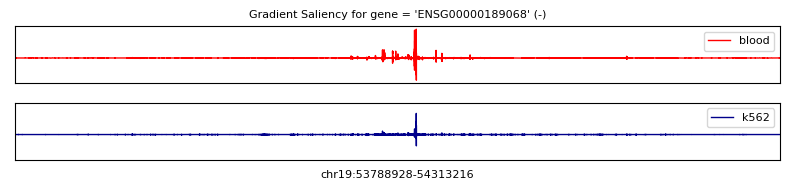

 - (Gradient score comparison against 'k562') - 
blood (r = 0.269)


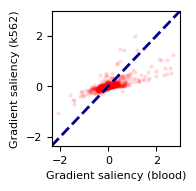

 - (Differential gradient score of k562 against 'mean') -


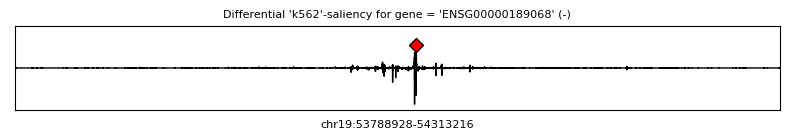

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 275078
 - max_pos (abs) = 54064006
 - chr19:54063910-54064102
blood


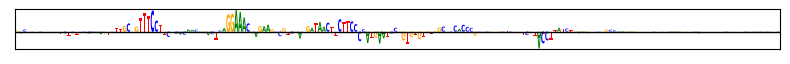

k562


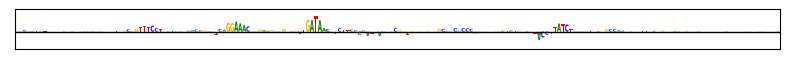

--------------------

-- Example = 37 --
 - ENSG00000257335(+)
 - chr7:141802295-142326583
 -- min_val = -0.871
 -- max_val = 1.355
 - (Gradient score profiles per tissue) - 


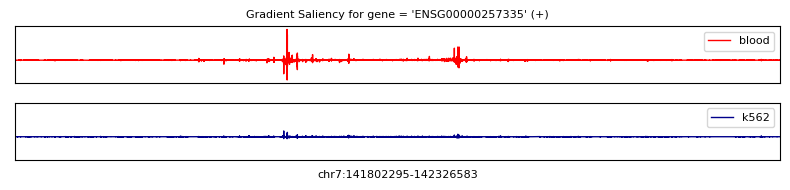

 - (Gradient score comparison against 'k562') - 
blood (r = 0.254)


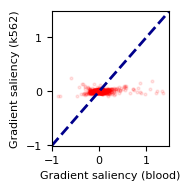

 - (Differential gradient score of k562 against 'mean') -


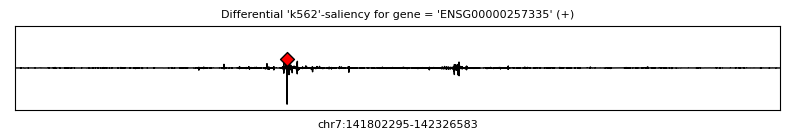

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 186729
 - max_pos (abs) = 141989024
 - chr7:141988928-141989120
blood


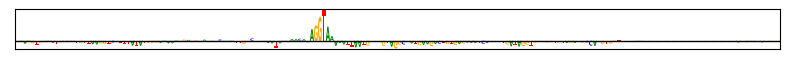

k562


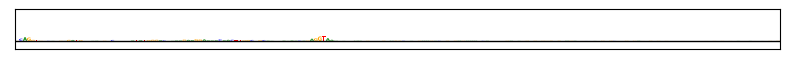

--------------------

-- Example = 38 --
 - ENSG00000164047(+)
 - chr3:47962314-48486602
 -- min_val = -1.195
 -- max_val = 2.357
 - (Gradient score profiles per tissue) - 


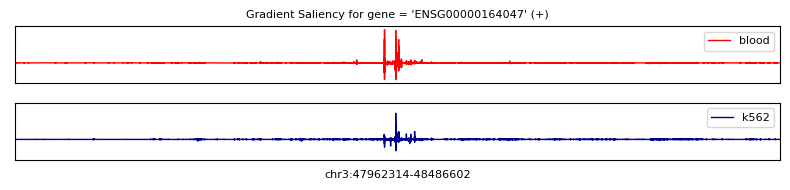

 - (Gradient score comparison against 'k562') - 
blood (r = 0.153)


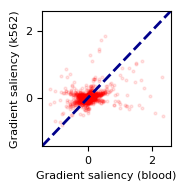

 - (Differential gradient score of k562 against 'mean') -


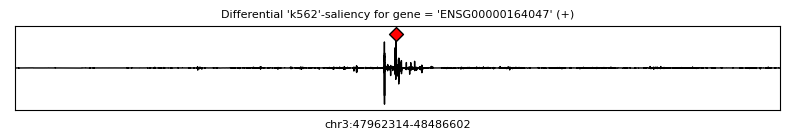

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 261088
 - max_pos (abs) = 48223402
 - chr3:48223306-48223498
blood


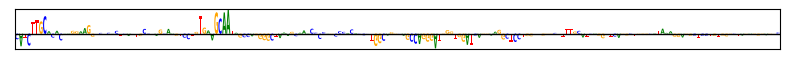

k562


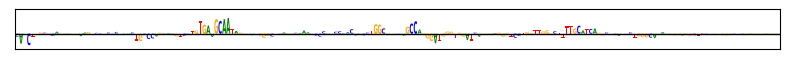

--------------------

-- Example = 39 --
 - ENSG00000085265(-)
 - chr9:134645268-135169556
 -- min_val = -2.066
 -- max_val = 2.525
 - (Gradient score profiles per tissue) - 


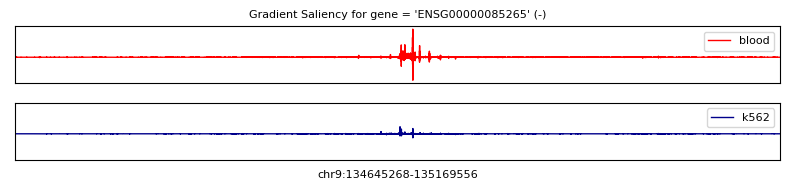

 - (Gradient score comparison against 'k562') - 
blood (r = 0.148)


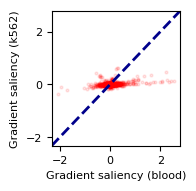

 - (Differential gradient score of k562 against 'mean') -


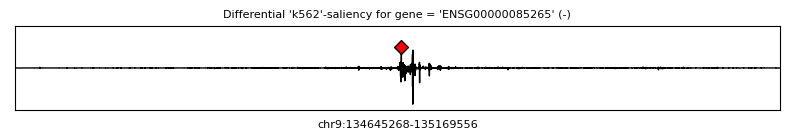

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 264844
 - max_pos (abs) = 134910112
 - chr9:134910016-134910208
blood


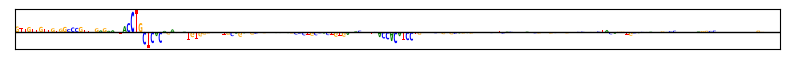

k562


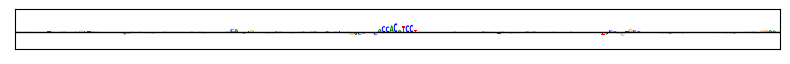

--------------------

-- Example = 40 --
 - ENSG00000133742(-)
 - chr8:85070557-85594845
 -- min_val = -0.846
 -- max_val = 3.766
 - (Gradient score profiles per tissue) - 


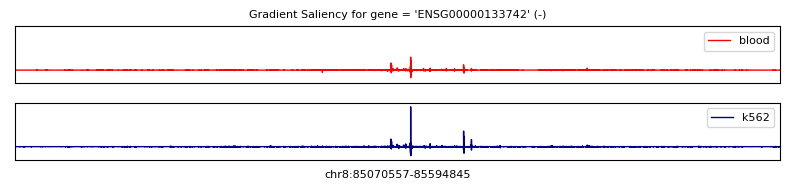

 - (Gradient score comparison against 'k562') - 
blood (r = 0.571)


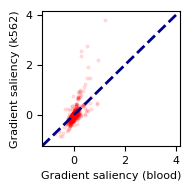

 - (Differential gradient score of k562 against 'mean') -


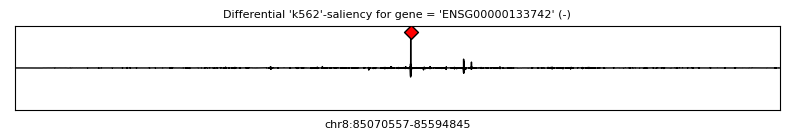

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 271221
 - max_pos (abs) = 85341778
 - chr8:85341682-85341874
blood


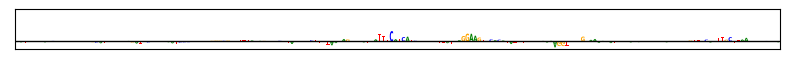

k562


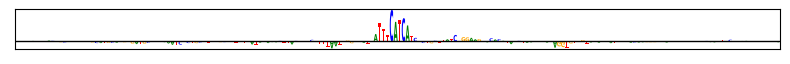

--------------------

-- Example = 41 --
 - ENSG00000166527(+)
 - chr12:8257745-8782033
 -- min_val = -0.4143
 -- max_val = 1.727
 - (Gradient score profiles per tissue) - 


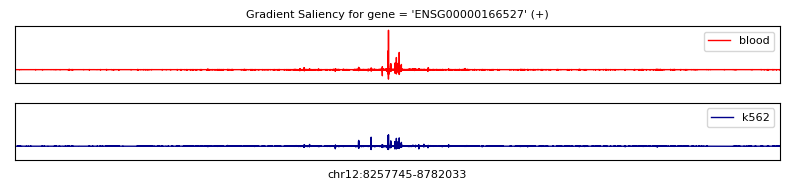

 - (Gradient score comparison against 'k562') - 
blood (r = 0.241)


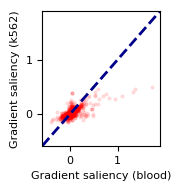

 - (Differential gradient score of k562 against 'mean') -


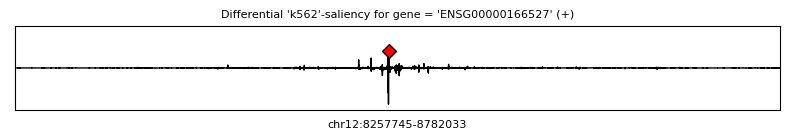

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 256047
 - max_pos (abs) = 8513792
 - chr12:8513696-8513888
blood


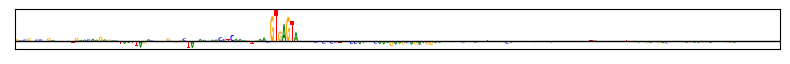

k562


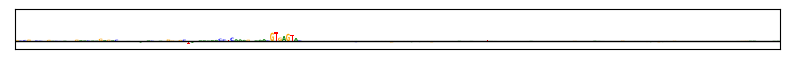

--------------------

-- Example = 42 --
 - ENSG00000163736(-)
 - chr4:73725041-74249329
 -- min_val = -0.7383
 -- max_val = 1.041
 - (Gradient score profiles per tissue) - 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


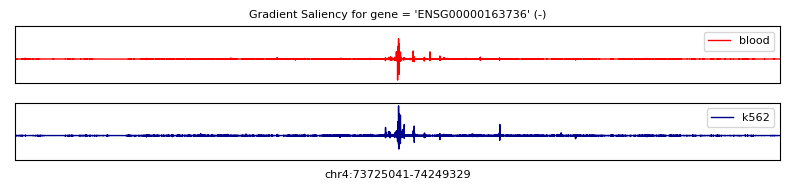

 - (Gradient score comparison against 'k562') - 
blood (r = 0.206)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


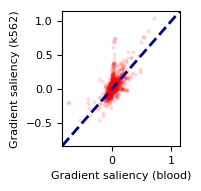

 - (Differential gradient score of k562 against 'mean') -


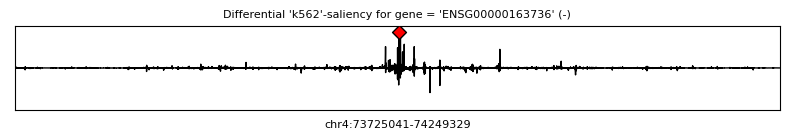

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263143
 - max_pos (abs) = 73988184
 - chr4:73988088-73988280
blood


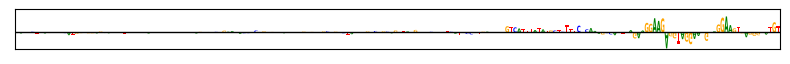

k562


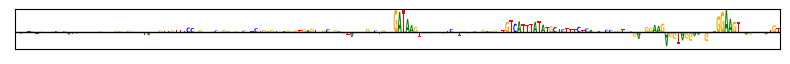

--------------------

-- Example = 43 --
 - ENSG00000180549(-)
 - chr9:136768876-137293164
 -- min_val = -0.6914
 -- max_val = 1.525
 - (Gradient score profiles per tissue) - 


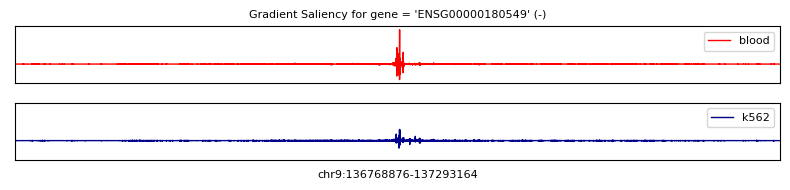

 - (Gradient score comparison against 'k562') - 
blood (r = 0.162)


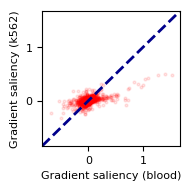

 - (Differential gradient score of k562 against 'mean') -


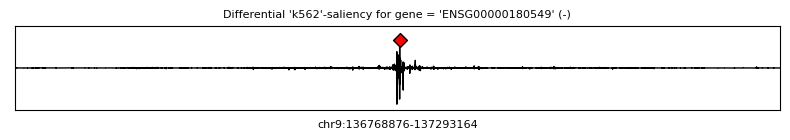

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 263680
 - max_pos (abs) = 137032556
 - chr9:137032460-137032652
blood


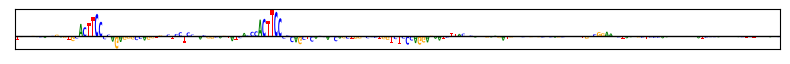

k562


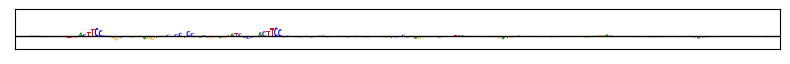

--------------------

-- Example = 44 --
 - ENSG00000100985(+)
 - chr20:45750380-46274668
 -- min_val = -1.052
 -- max_val = 2.242
 - (Gradient score profiles per tissue) - 


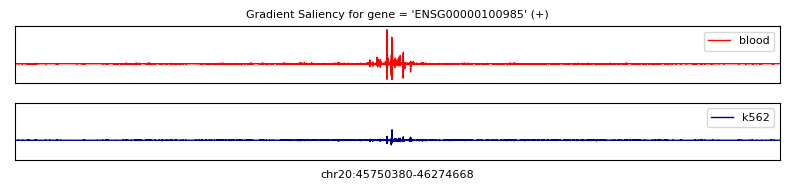

 - (Gradient score comparison against 'k562') - 
blood (r = 0.158)


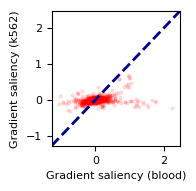

 - (Differential gradient score of k562 against 'mean') -


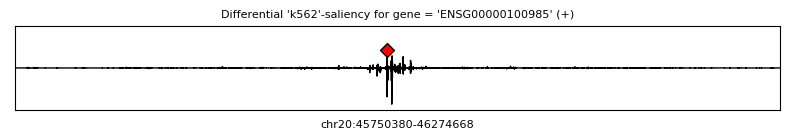

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 254991
 - max_pos (abs) = 46005371
 - chr20:46005275-46005467
blood


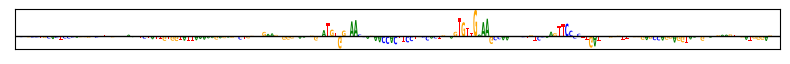

k562


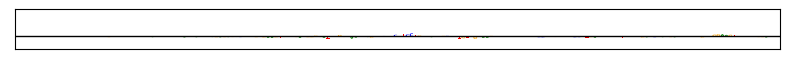

--------------------

-- Example = 45 --
 - ENSG00000076662(-)
 - chr19:10073518-10597806
 -- min_val = -1.727
 -- max_val = 2.86
 - (Gradient score profiles per tissue) - 


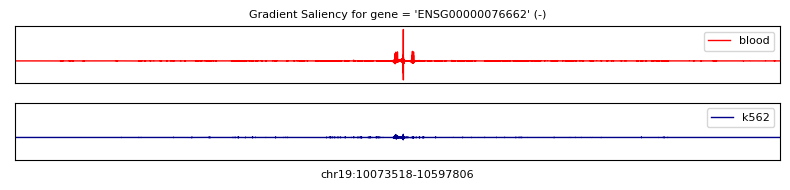

 - (Gradient score comparison against 'k562') - 
blood (r = 0.195)


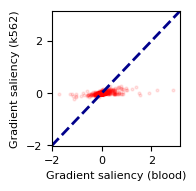

 - (Differential gradient score of k562 against 'mean') -


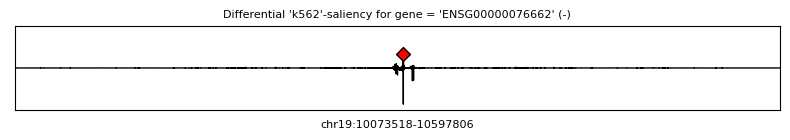

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 266123
 - max_pos (abs) = 10339641
 - chr19:10339545-10339737
blood


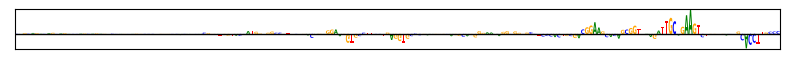

k562


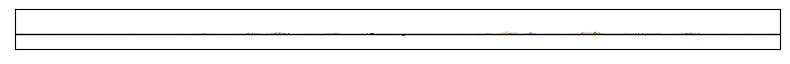

--------------------

-- Example = 46 --
 - ENSG00000142405(-)
 - chr19:53545852-54070140
 -- min_val = -1.094
 -- max_val = 1.516
 - (Gradient score profiles per tissue) - 


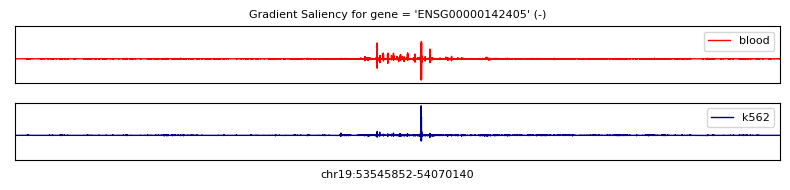

 - (Gradient score comparison against 'k562') - 
blood (r = 0.153)


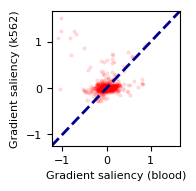

 - (Differential gradient score of k562 against 'mean') -


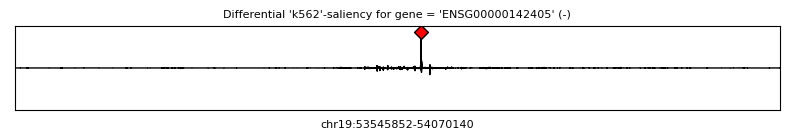

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 278413
 - max_pos (abs) = 53824265
 - chr19:53824169-53824361
blood


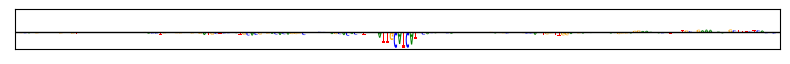

k562


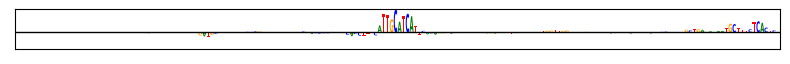

--------------------

-- Example = 47 --
 - ENSG00000169704(+)
 - chr3:128799745-129324033
 -- min_val = -2.07
 -- max_val = 2.715
 - (Gradient score profiles per tissue) - 


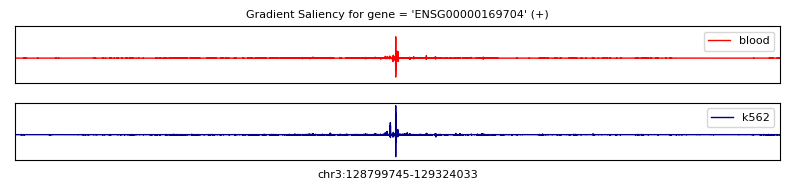

 - (Gradient score comparison against 'k562') - 
blood (r = 0.419)


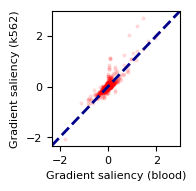

 - (Differential gradient score of k562 against 'mean') -


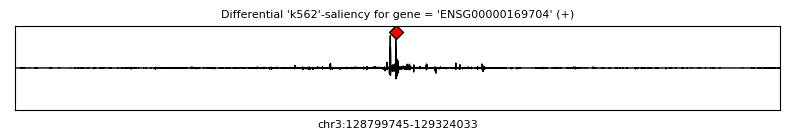

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 260967
 - max_pos (abs) = 129060712
 - chr3:129060616-129060808
blood


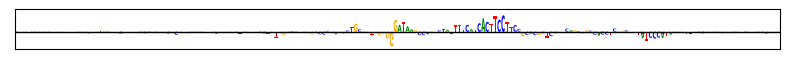

k562


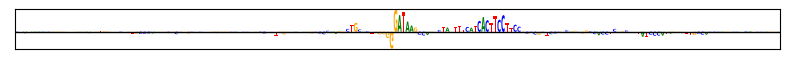

--------------------

-- Example = 48 --
 - ENSG00000239998(+)
 - chr19:54322467-54846755
 -- min_val = -0.7
 -- max_val = 1.875
 - (Gradient score profiles per tissue) - 


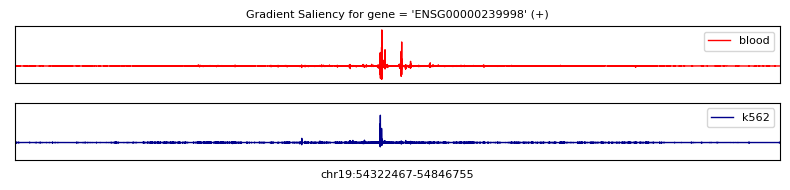

 - (Gradient score comparison against 'k562') - 
blood (r = 0.029)


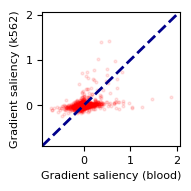

 - (Differential gradient score of k562 against 'mean') -


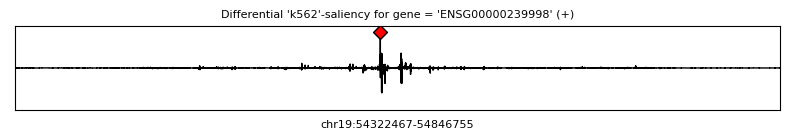

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 250437
 - max_pos (abs) = 54572904
 - chr19:54572808-54573000
blood


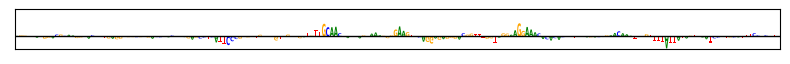

k562


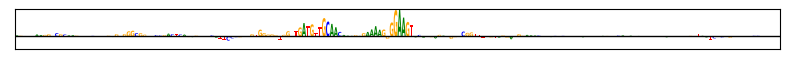

--------------------

-- Example = 49 --
 - ENSG00000174837(+)
 - chr19:6655798-7180086
 -- min_val = -1.859
 -- max_val = 2.254
 - (Gradient score profiles per tissue) - 


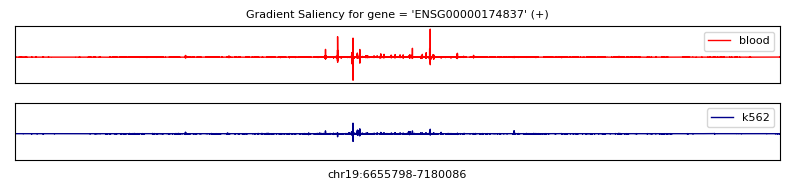

 - (Gradient score comparison against 'k562') - 
blood (r = 0.253)


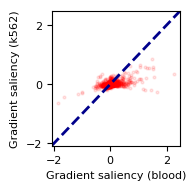

 - (Differential gradient score of k562 against 'mean') -


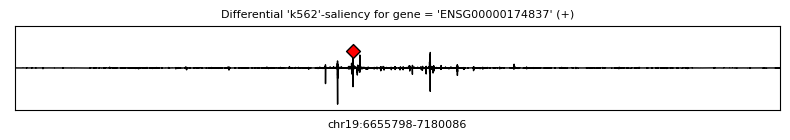

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 231796
 - max_pos (abs) = 6887594
 - chr19:6887498-6887690
blood


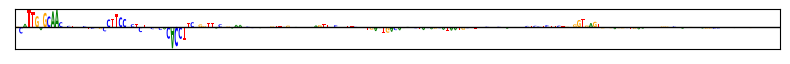

k562


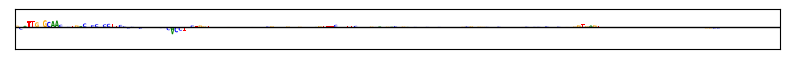

--------------------



In [7]:
#Enumerate and visualize attributions (relative fold changes); k562

save_figs = True
save_prefix = 'attribution_figs/borzoi_v2_diff_expr_grads_k562_vs_blood_4_folds'

save_index = [0, 1, 23, 32, 42]

#Select tissue to find maximally differential score locus for
main_tissue_ix = 1

#Visualization parameters
logo_width = 192

top_n = 50

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8

tissue_colors = ['red', 'darkblue', 'darkorange', 'brown', 'darkgreen']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    save_figs_curr = False
    if save_figs and example_ix in set(save_index) :
        save_figs_curr = True
    
    print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scores_example_ix_' + str(example_ix) + ".eps")
    
    plt.show()
    
    print(" - (Gradient score comparison against '" + gtex_tissues[main_tissue_ix] + "') - ")

    #Scatter plots of pairs of tissue-specific gradient scores
    f, ax = plt.subplots(1, len(gtex_tissues)-1, figsize=((len(gtex_tissues)-1) * 2, 2))
    
    if len(gtex_tissues)-1 == 1 :
        ax = [ax]
    
    #Gradient saliency for main tissue
    score_2 = scores[main_tissue_ix, example_ix, ...]

    #Loop over (other) tissues
    ax_ix = 0
    for tissue_ix in range(len(gtex_tissues)) :

        if tissue_ix != main_tissue_ix :
            
            #Gradient saliency for other tissue
            score_1 = scores[tissue_ix, example_ix, ...]
            
            #Compute spearman correlation between scores
            r_val, _ = spearmanr(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1))
            
            #Print stats
            print(gtex_tissues[tissue_ix] + " (r = " + str(round(r_val, 3)) + ")")

            #Scatter plot of scores
            ax[ax_ix].scatter(np.sum(score_1, axis=-1), np.sum(score_2, axis=-1), s=4, color=tissue_colors[tissue_ix], alpha=0.1)

            ax[ax_ix].plot([min_val, max_val], [min_val, max_val], linewidth=2, linestyle='--', color='darkblue')

            plt.sca(ax[ax_ix])
            
            plt.xlim(min_val, max_val)
            plt.ylim(min_val, max_val)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)

            plt.xlabel("Gradient saliency (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            ax_ix += 1

    plt.sca(ax[0])
    plt.ylabel("Gradient saliency (" + gtex_tissues[main_tissue_ix] + ")", fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_scatters_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Differential gradient score of " + gtex_tissues[main_tissue_ix] + " against 'mean') -")

    #Get main tissue scores and background scores
    score_2 = scores[main_tissue_ix, example_ix, ...]
    score_1 = np.mean(scores[np.arange(len(gtex_tissues)) != main_tissue_ix, example_ix, ...], axis=0)

    #Compute differential scores
    diff_score = np.sum(score_2 - score_1, axis=-1)
    
    #Apply gaussian filter
    if use_gaussian :
        diff_score = gaussian_filter1d(diff_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(diff_score[min_padding:-min_padding]) + min_padding
    min_pos = np.argmin(diff_score[min_padding:-min_padding]) + min_padding

    max_val = np.max(diff_score[min_padding:-min_padding])
    min_val = np.min(diff_score[min_padding:-min_padding])
    
    max_abs_val = max(np.abs(max_val), np.abs(min_val))

    #Plot differential scores
    f = plt.figure(figsize=(8, 1.5))

    plt.plot(np.arange(seqs.shape[1]), diff_score, color='black', linewidth=1, linestyle='-')
    
    plt.scatter([max_pos], [max_val], color='red', marker='D', s=50, linewidth=1, edgecolor='black', zorder=1000)

    plt.xlim(0, seqs.shape[1])
    plt.ylim(-max_abs_val*1.15, max_abs_val*1.15)
    
    plt.xticks([], [])
    plt.yticks([], [])

    plt.title("Differential '" + gtex_tissues[main_tissue_ix] + "'-saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.tight_layout()

    if save_figs_curr :
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".png", dpi=300, transparent=False)
        plt.savefig(save_prefix + '_diff_scores_example_ix_' + str(example_ix) + ".eps")

    plt.show()

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 0.75),
            plot_y_ticks=False,
            save_figs=save_figs_curr,
            fig_name=save_prefix + '_logo_example_ix_' + str(example_ix) + '_tissue_ix_' + str(tissue_ix),
        )
    
    print("--------------------")
    print("")
